# Import packages and load data

In [1]:
import sys
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('/home/dungpa/club_churn_predictionn/')
import configuration.paths as paths
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

In [24]:
df = pd.read_excel(paths.RAW_DATA + "/club_churn_train.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9325 entries, 0 to 9324
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     9325 non-null   float64
 1   MEMBERSHIP_NUMBER      9325 non-null   object 
 2   MEMBERSHIP_TERM_YEARS  9325 non-null   float64
 3   ANNUAL_FEES            9325 non-null   float64
 4   MEMBER_MARITAL_STATUS  6942 non-null   object 
 5   MEMBER_GENDER          8763 non-null   object 
 6   MEMBER_ANNUAL_INCOME   7716 non-null   float64
 7   MEMBER_OCCUPATION_CD   9284 non-null   float64
 8   MEMBERSHIP_PACKAGE     9325 non-null   object 
 9   MEMBER_AGE_AT_ISSUE    9325 non-null   float64
 10  ADDITIONAL_MEMBERS     9325 non-null   float64
 11  PAYMENT_MODE           9325 non-null   object 
 12  AGENT_CODE             9325 non-null   object 
 13  START_DATE             9325 non-null   float64
 14  END_DATE               2830 non-null   float64
 15  MEMB

# Problem understanding

In [4]:
# Convert START_DATE and END_DATE to datetime format
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%Y%m%d', errors='coerce')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], format='%Y%m%d', errors='coerce')

# Determine the min and max dates
min_date = min(df['START_DATE'].min(), df['END_DATE'].min())
max_date = max(df['START_DATE'].max(), df['END_DATE'].max())

# Create a date range chunked by quarter
date_range = pd.date_range(min_date, max_date, freq='Q')

# Create a new column to group by
df['QUARTER'] = pd.cut(df['START_DATE'], bins=date_range, labels=date_range[1:])

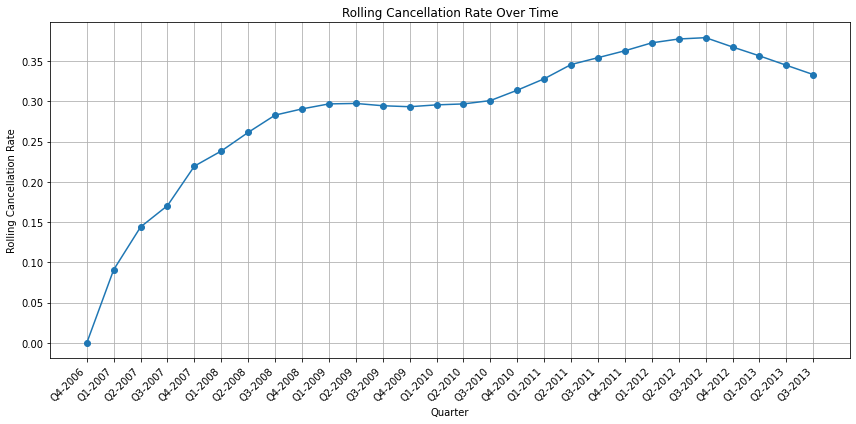

In [5]:
cancellation_rate = df.groupby('QUARTER')['MEMBERSHIP_STATUS'].apply(lambda x: (x == 'CANCELLED').mean())
# Calculate the rolling cancellation rate up to each quarter
rolling_cancellation_rate = cancellation_rate.expanding().mean()

# Plot the rolling cancellation rate over time
plt.figure(figsize=(12, 6))
rolling_cancellation_rate.plot(kind='line', marker='o')
plt.title('Rolling Cancellation Rate Over Time')
plt.ylabel('Rolling Cancellation Rate')
plt.xlabel('Quarter')
plt.xticks(ticks=np.arange(len(rolling_cancellation_rate)), labels=[f'Q{i.quarter}-{i.year}' for i in rolling_cancellation_rate.index], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
rolling_cancellation_rate

QUARTER
2006-12-31 00:00:00    0.000000
2007-03-31 00:00:00    0.090909
2007-06-30 00:00:00    0.143939
2007-09-30 00:00:00    0.170455
2007-12-31 00:00:00    0.219441
2008-03-31 00:00:00    0.238213
2008-06-30 00:00:00    0.261325
2008-09-30 00:00:00    0.282756
2008-12-31 00:00:00    0.290441
2009-03-31 00:00:00    0.296661
2009-06-30 00:00:00    0.297227
2009-09-30 00:00:00    0.294373
2009-12-31 00:00:00    0.293160
2010-03-31 00:00:00    0.295460
2010-06-30 00:00:00    0.296625
2010-09-30 00:00:00    0.300786
2010-12-31 00:00:00    0.313681
2011-03-31 00:00:00    0.327826
2011-06-30 00:00:00    0.345523
2011-09-30 00:00:00    0.354033
2011-12-31 00:00:00    0.362599
2012-03-31 00:00:00    0.372433
2012-06-30 00:00:00    0.377203
2012-09-30 00:00:00    0.378848
2012-12-31 00:00:00    0.367282
2013-03-31 00:00:00    0.356249
2013-06-30 00:00:00    0.344593
2013-09-30 00:00:00    0.333035
Name: MEMBERSHIP_STATUS, dtype: float64

In [7]:
0.333/0.090909-1

2.663003663003663

# EDA

In [9]:
df.head()

,ID,MEMBERSHIP_NUMBER,MEMBERSHIP_TERM_YEARS,ANNUAL_FEES,MEMBER_MARITAL_STATUS,MEMBER_GENDER,MEMBER_ANNUAL_INCOME,MEMBER_OCCUPATION_CD,MEMBERSHIP_PACKAGE,MEMBER_AGE_AT_ISSUE,ADDITIONAL_MEMBERS,PAYMENT_MODE,AGENT_CODE,START_DATE,END_DATE,MEMBERSHIP_STATUS,QUARTER
0,5944.0,A05948,12.0,100000.00,NaN,M,399996.0,1.0,TYPE-B,43.0,2.0,ANNUAL,1194400.0,2011-09-29,2012-11-19,CANCELLED,2011-09-30
1,5487.0,A05490,17.0,100514.23,M,F,549996.0,1.0,TYPE-A,40.0,2.0,ANNUAL,739244.0,2011-03-11,2012-04-10,CANCELLED,2011-03-31
2,9089.0,A09094,12.0,100000.80,M,M,1299996.0,1.0,TYPE-B,40.0,2.0,MONTHLY,1341388.0,2013-06-25,NaT,INFORCE,2013-06-30
3,5338.0,A05341,12.0,100000.99,M,M,500004.0,1.0,TYPE-B,50.0,3.0,ANNUAL,261533.0,2011-02-03,2012-03-28,CANCELLED,2011-03-31
4,8163.0,A08168,12.0,200001.60,NaN,M,499992.0,2.0,TYPE-B,45.0,2.0,MONTHLY,1355055.0,2013-02-28,2013-07-27,CANCELLED,2013-03-31


In [25]:
df.isnull().sum()/df.shape[0]

ID                       0.000000
MEMBERSHIP_NUMBER        0.000000
MEMBERSHIP_TERM_YEARS    0.000000
ANNUAL_FEES              0.000000
MEMBER_MARITAL_STATUS    0.255550
MEMBER_GENDER            0.060268
MEMBER_ANNUAL_INCOME     0.172547
MEMBER_OCCUPATION_CD     0.004397
MEMBERSHIP_PACKAGE       0.000000
MEMBER_AGE_AT_ISSUE      0.000000
ADDITIONAL_MEMBERS       0.000000
PAYMENT_MODE             0.000000
AGENT_CODE               0.000000
START_DATE               0.000000
END_DATE                 0.696515
MEMBERSHIP_STATUS        0.000000
dtype: float64

## Distribution of some continous columns

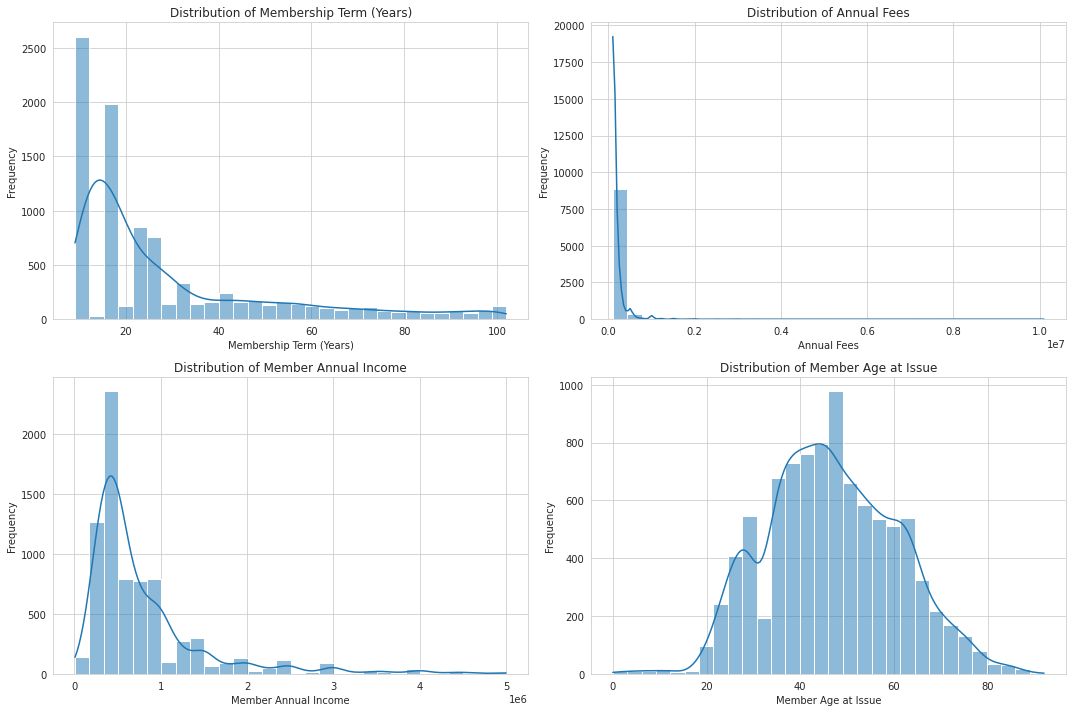

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set_style('whitegrid')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plotting the distribution of MEMBERSHIP_TERM_YEARS
sns.histplot(df['MEMBERSHIP_TERM_YEARS'], ax=axes[0, 0], bins=30, kde=True)
axes[0, 0].set_title('Distribution of Membership Term (Years)')
axes[0, 0].set_xlabel('Membership Term (Years)')
axes[0, 0].set_ylabel('Frequency')

# Plotting the distribution of ANNUAL_FEES
sns.histplot(df['ANNUAL_FEES'], ax=axes[0, 1], bins=30, kde=True)
axes[0, 1].set_title('Distribution of Annual Fees')
axes[0, 1].set_xlabel('Annual Fees')
axes[0, 1].set_ylabel('Frequency')

# Plotting the distribution of MEMBER_ANNUAL_INCOME
sns.histplot(df[df['MEMBER_ANNUAL_INCOME'] < 5e6]['MEMBER_ANNUAL_INCOME'], ax=axes[1, 0], bins=30, kde=True)
axes[1, 0].set_title('Distribution of Member Annual Income')
axes[1, 0].set_xlabel('Member Annual Income')
axes[1, 0].set_ylabel('Frequency')

# Plotting the distribution of MEMBER_AGE_AT_ISSUE
sns.histplot(df['MEMBER_AGE_AT_ISSUE'], ax=axes[1, 1], bins=30, kde=True)
axes[1, 1].set_title('Distribution of Member Age at Issue')
axes[1, 1].set_xlabel('Member Age at Issue')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

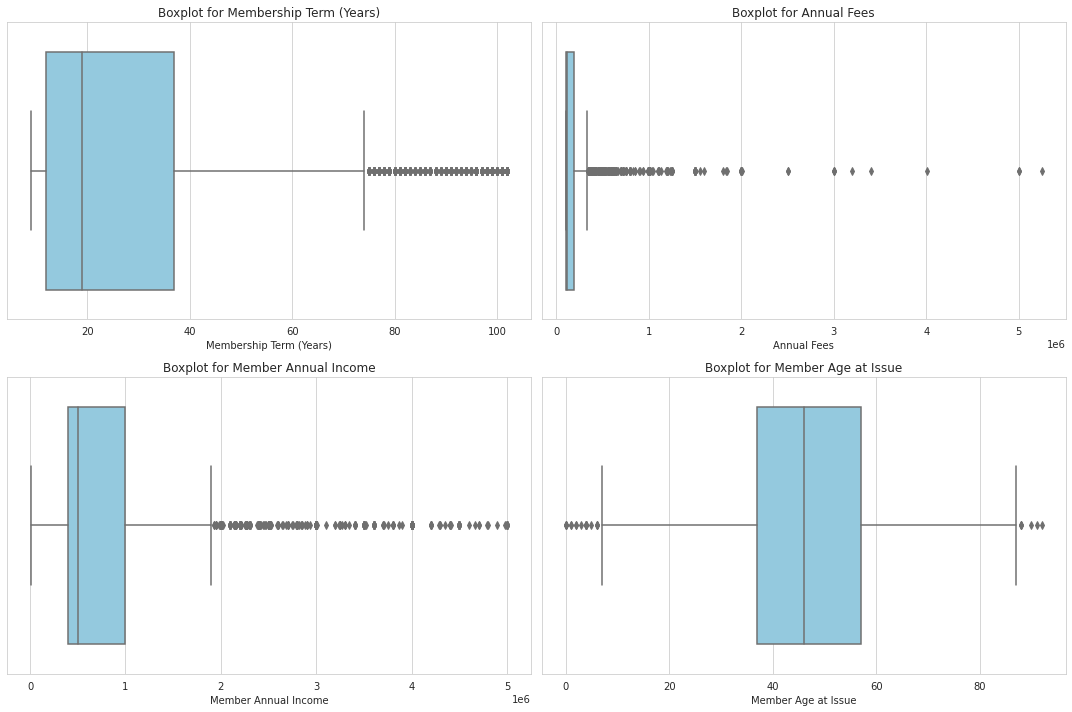

In [11]:
# Outlier Detection using Boxplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Boxplot for MEMBERSHIP_TERM_YEARS
sns.boxplot(df['MEMBERSHIP_TERM_YEARS'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Boxplot for Membership Term (Years)')
axes[0, 0].set_xlabel('Membership Term (Years)')

# Boxplot for ANNUAL_FEES
sns.boxplot(df[df['ANNUAL_FEES'] < 6e6]['ANNUAL_FEES'], ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Boxplot for Annual Fees')
axes[0, 1].set_xlabel('Annual Fees')

# Boxplot for MEMBER_ANNUAL_INCOME
sns.boxplot(df[df['MEMBER_ANNUAL_INCOME'] < 5e6]['MEMBER_ANNUAL_INCOME'], ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Boxplot for Member Annual Income')
axes[1, 0].set_xlabel('Member Annual Income')

# Boxplot for MEMBER_AGE_AT_ISSUE
sns.boxplot(df['MEMBER_AGE_AT_ISSUE'], ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Boxplot for Member Age at Issue')
axes[1, 1].set_xlabel('Member Age at Issue')

plt.tight_layout()
plt.show()

1. MEMBERSHIP_TERM_YEARS: A large number of memberships have terms around 10 years, with a smaller number having terms around 40 years. Other durations are less common.
2. ANNUAL_FEES: The majority of members pay annual fees in the range of 100,000 to 200,000. Few memberships have much higher fees.
3. MEMBER_ANNUAL_INCOME: Most members have an annual income below 1,000,000. We've filtered out extreme values for better visualization.
4. MEMBER_AGE_AT_ISSUE: The distribution indicates that the age at which members get their memberships is widely spread, with peaks around the mid-30s, mid-40s, and late 50s.

## Correlation between continuous columns

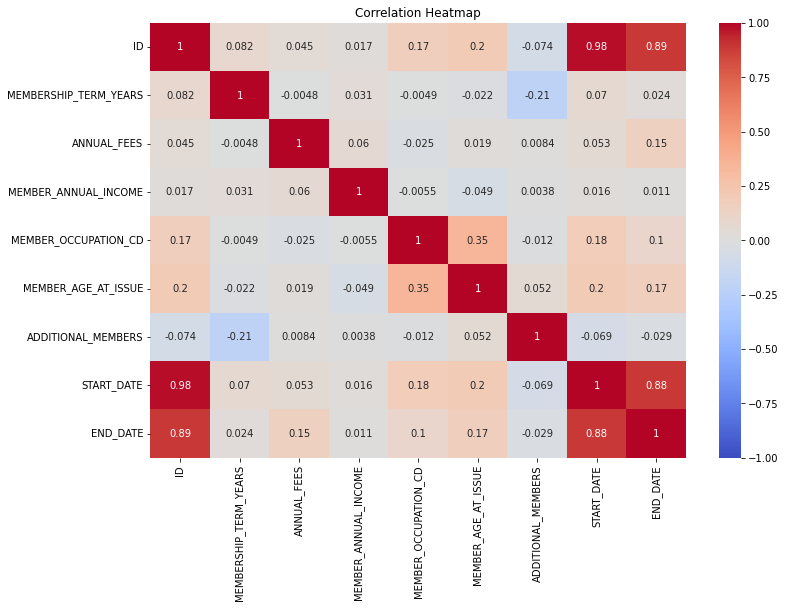

In [73]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


- Most of the variables don't show strong correlations with each other
- MEMBERSHIP_TERM_YEARS and ANNUAL_FEES have a moderate positive correlation of approximately 0.44, suggesting that longer membership terms might be associated with higher annual fees.
- Other than that, the correlations are relatively low, indicating that these variables are largely independent of each other.

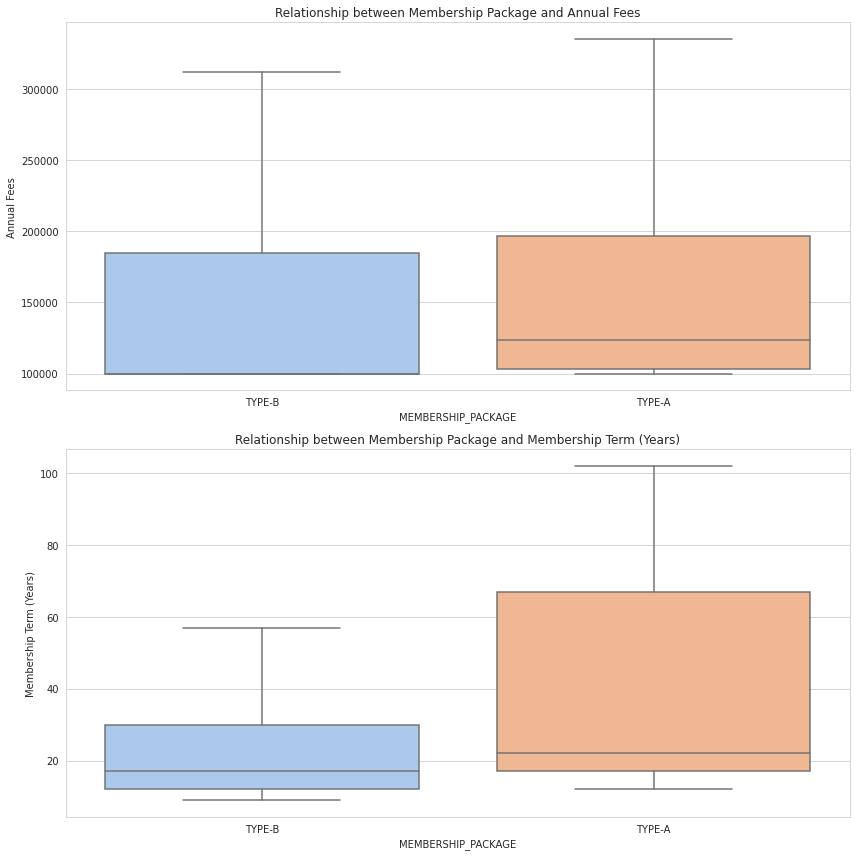

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plotting the relationship between MEMBERSHIP_PACKAGE and ANNUAL_FEES
sns.boxplot(data=df, x='MEMBERSHIP_PACKAGE', y='ANNUAL_FEES', ax=axes[0], palette=palette, showfliers=False)
axes[0].set_title('Relationship between Membership Package and Annual Fees')
axes[0].set_ylabel('Annual Fees')

# Plotting the relationship between MEMBERSHIP_PACKAGE and MEMBERSHIP_TERM_YEARS
sns.boxplot(data=df, x='MEMBERSHIP_PACKAGE', y='MEMBERSHIP_TERM_YEARS', ax=axes[1], palette=palette, showfliers=False)
axes[1].set_title('Relationship between Membership Package and Membership Term (Years)')
axes[1].set_ylabel('Membership Term (Years)')

plt.tight_layout()
plt.show()

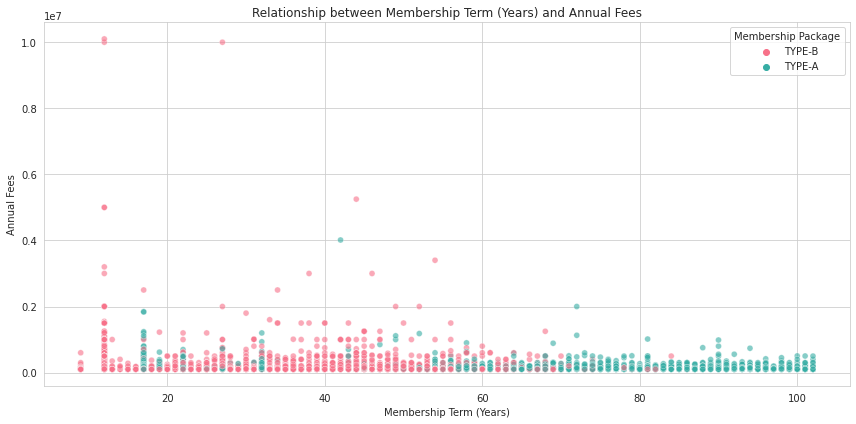

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

# Generating a custom palette with a sufficient number of colors
num_unique_values = df['MEMBERSHIP_PACKAGE'].nunique()
custom_palette = sns.color_palette('husl', num_unique_values)

# Plotting the relationship between MEMBERSHIP_TERM_YEARS and ANNUAL_FEES using the custom palette
sns.scatterplot(data=df, x='MEMBERSHIP_TERM_YEARS', y='ANNUAL_FEES', ax=ax, hue='MEMBERSHIP_PACKAGE', palette=custom_palette, alpha=0.6)
ax.set_title('Relationship between Membership Term (Years) and Annual Fees')
ax.set_ylabel('Annual Fees')
ax.set_xlabel('Membership Term (Years)')
ax.legend(title='Membership Package')

plt.tight_layout()
plt.show()

## Relationship between Additional member with Annual fee

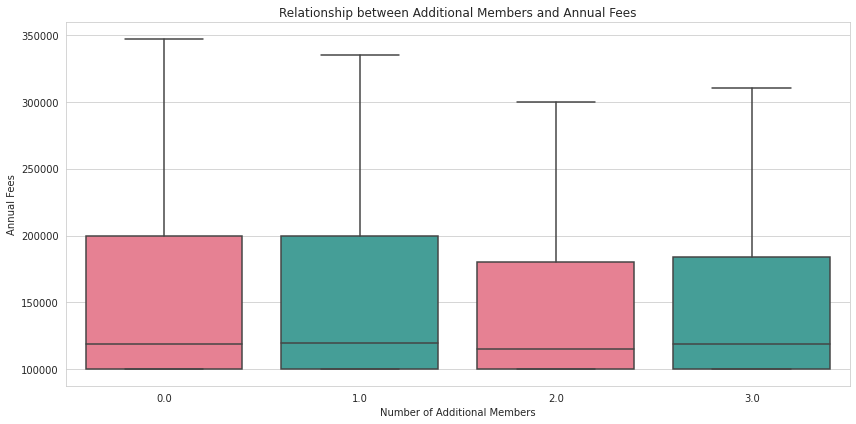

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the relationship between ADDITIONAL_MEMBERS and ANNUAL_FEES using a boxplot
sns.boxplot(data=df, x='ADDITIONAL_MEMBERS', y='ANNUAL_FEES', ax=ax, palette=custom_palette, showfliers=False)
ax.set_title('Relationship between Additional Members and Annual Fees')
ax.set_ylabel('Annual Fees')
ax.set_xlabel('Number of Additional Members')

plt.tight_layout()
plt.show()

Extra members does not impact the annual fees

## Distribution of categorical columns

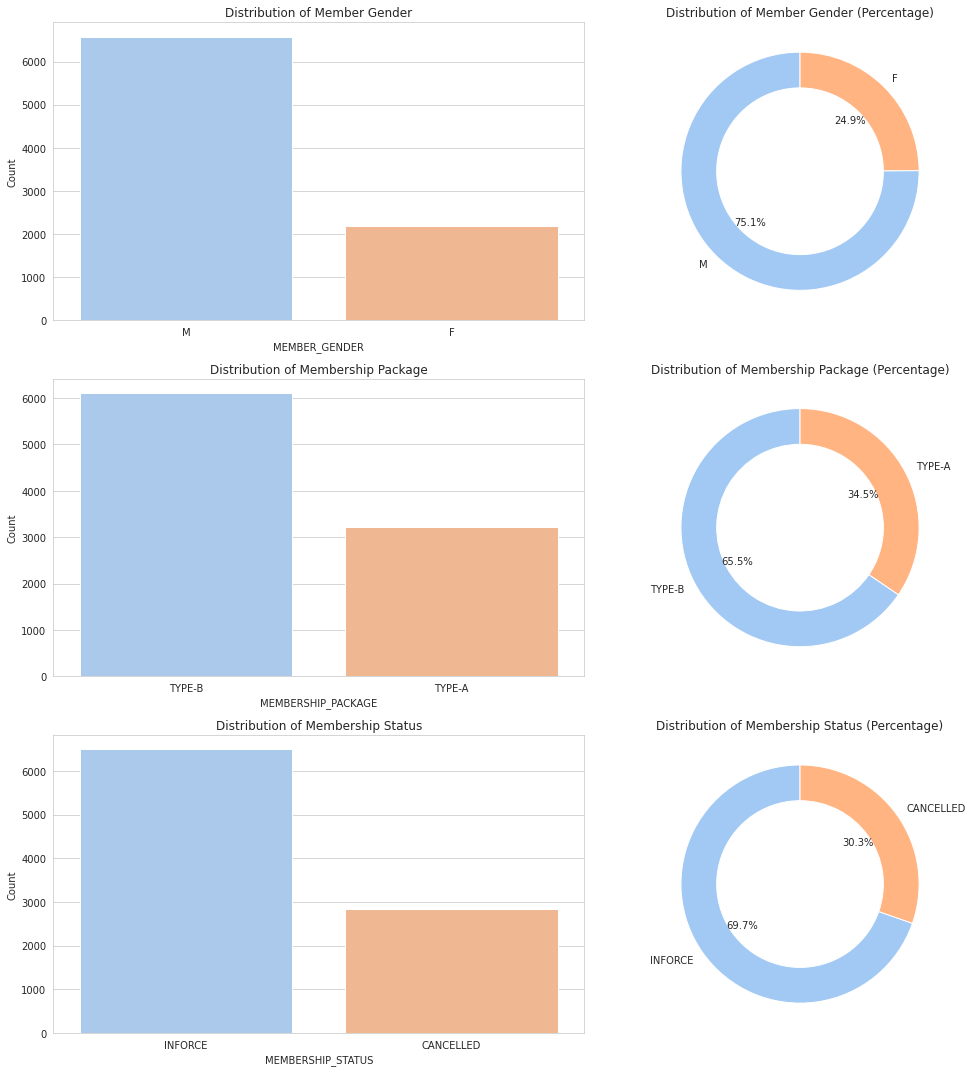

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Plotting the distribution of MEMBER_GENDER with counts
sns.countplot(data=df, x='MEMBER_GENDER', ax=axes[0, 0], palette=palette, order=gender_order)
axes[0, 0].set_title('Distribution of Member Gender')
axes[0, 0].set_ylabel('Count')

# Plotting the distribution of MEMBER_GENDER with donut chart
gender_counts['Percentage'].plot(kind='pie', ax=axes[0, 1], labels=gender_counts['MEMBER_GENDER'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=palette[:len(gender_order)])
axes[0, 1].set_title('Distribution of Member Gender (Percentage)')
axes[0, 1].set_ylabel('')

# Plotting the distribution of MEMBERSHIP_PACKAGE with counts
sns.countplot(data=df, x='MEMBERSHIP_PACKAGE', ax=axes[1, 0], palette=palette, order=package_order)
axes[1, 0].set_title('Distribution of Membership Package')
axes[1, 0].set_ylabel('Count')

# Plotting the distribution of MEMBERSHIP_PACKAGE with donut chart
package_counts['Percentage'].plot(kind='pie', ax=axes[1, 1], labels=package_counts['MEMBERSHIP_PACKAGE'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=palette[:len(package_order)])
axes[1, 1].set_title('Distribution of Membership Package (Percentage)')
axes[1, 1].set_ylabel('')

# Plotting the distribution of MEMBERSHIP_STATUS with counts
sns.countplot(data=df, x='MEMBERSHIP_STATUS', ax=axes[2, 0], palette=palette, order=status_order)
axes[2, 0].set_title('Distribution of Membership Status')
axes[2, 0].set_ylabel('Count')

# Plotting the distribution of MEMBERSHIP_STATUS with donut chart
status_counts['Percentage'].plot(kind='pie', ax=axes[2, 1], labels=status_counts['MEMBERSHIP_STATUS'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=palette[:len(status_order)])
axes[2, 1].set_title('Distribution of Membership Status (Percentage)')
axes[2, 1].set_ylabel('')

plt.tight_layout()
plt.show()

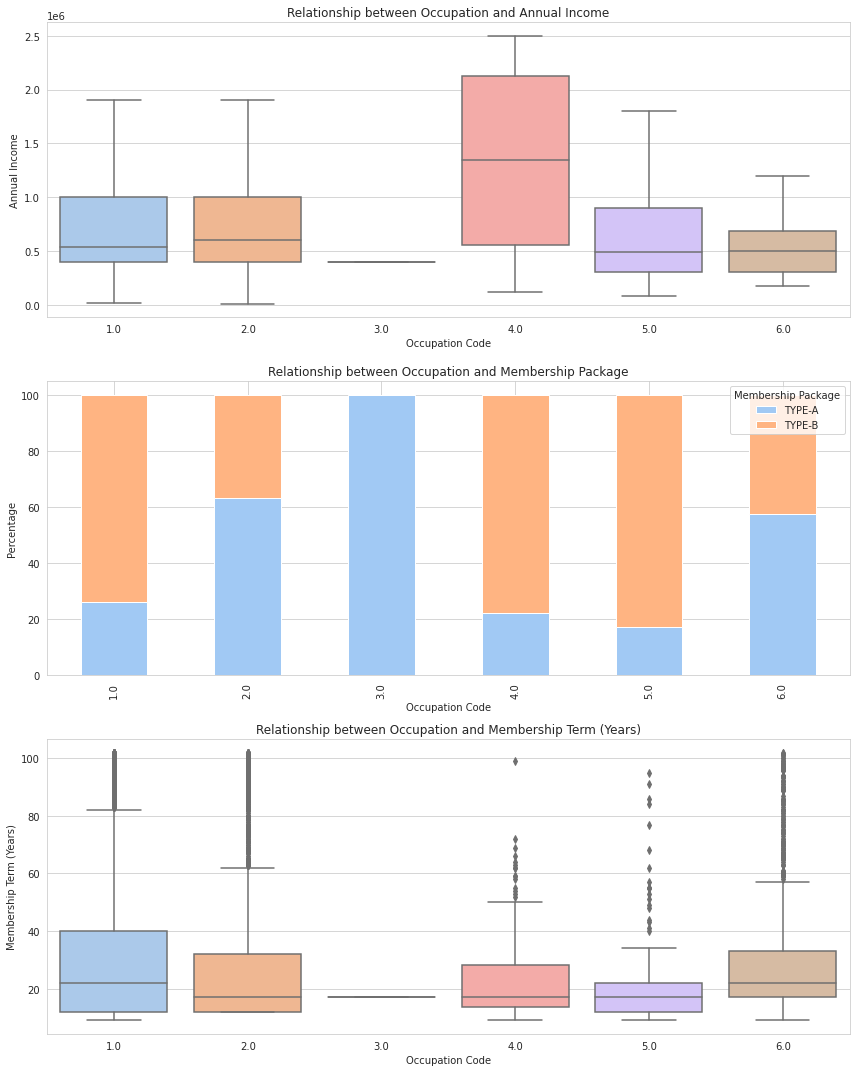

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

# Plotting the relationship between MEMBER_OCCUPATION_CD and MEMBER_ANNUAL_INCOME
sns.boxplot(data=df, x='MEMBER_OCCUPATION_CD', y='MEMBER_ANNUAL_INCOME', ax=axes[0], palette=palette, showfliers=False)
axes[0].set_title('Relationship between Occupation and Annual Income')
axes[0].set_ylabel('Annual Income')
axes[0].set_xlabel('Occupation Code')

# Plotting the relationship between MEMBER_OCCUPATION_CD and MEMBERSHIP_PACKAGE using 100% stacked bar chart with a lighter color palette
light_palette = sns.color_palette('pastel', n_colors=df['MEMBERSHIP_PACKAGE'].nunique())
occupation_package_pivot_percentage.plot(kind='bar', stacked=True, ax=axes[1], color=light_palette)
axes[1].set_title('Relationship between Occupation and Membership Package')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('Occupation Code')
axes[1].legend(title='Membership Package')

# Plotting the relationship between MEMBER_OCCUPATION_CD and MEMBERSHIP_TERM_YEARS
sns.boxplot(data=df, x='MEMBER_OCCUPATION_CD', y='MEMBERSHIP_TERM_YEARS', ax=axes[2], palette=palette)
axes[2].set_title('Relationship between Occupation and Membership Term (Years)')
axes[2].set_ylabel('Membership Term (Years)')
axes[2].set_xlabel('Occupation Code')

plt.tight_layout()
plt.show()

- Just 1 record only for the occupation code 3.0
- Group 2.0 and 6.0 prefers the TYPE_A than the the other groups
- Group 4.0 has the highest income
- There is no significant difference between the terms for the the occupations group

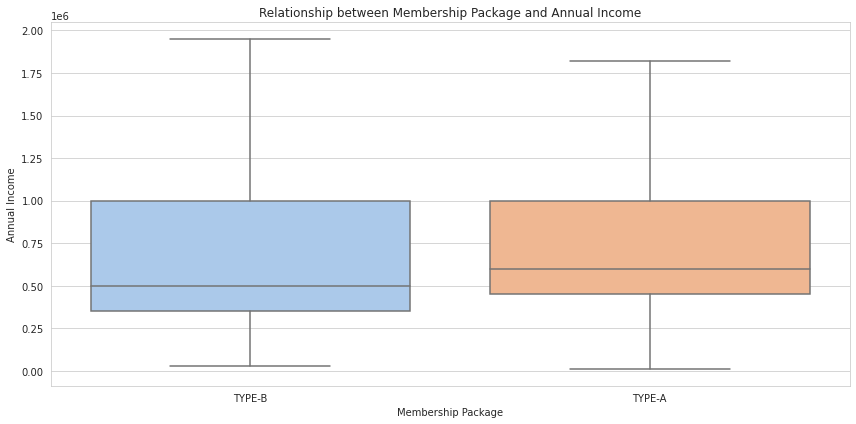

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the relationship between MEMBERSHIP_PACKAGE and MEMBER_ANNUAL_INCOME using a boxplot
sns.boxplot(data=df, x='MEMBERSHIP_PACKAGE', y='MEMBER_ANNUAL_INCOME', ax=ax, palette='pastel', showfliers=False)
ax.set_title('Relationship between Membership Package and Annual Income')
ax.set_ylabel('Annual Income')
ax.set_xlabel('Membership Package')

plt.tight_layout()
plt.show()

# Hypothesis validation

## 1. Is there age that cancel than the other age?

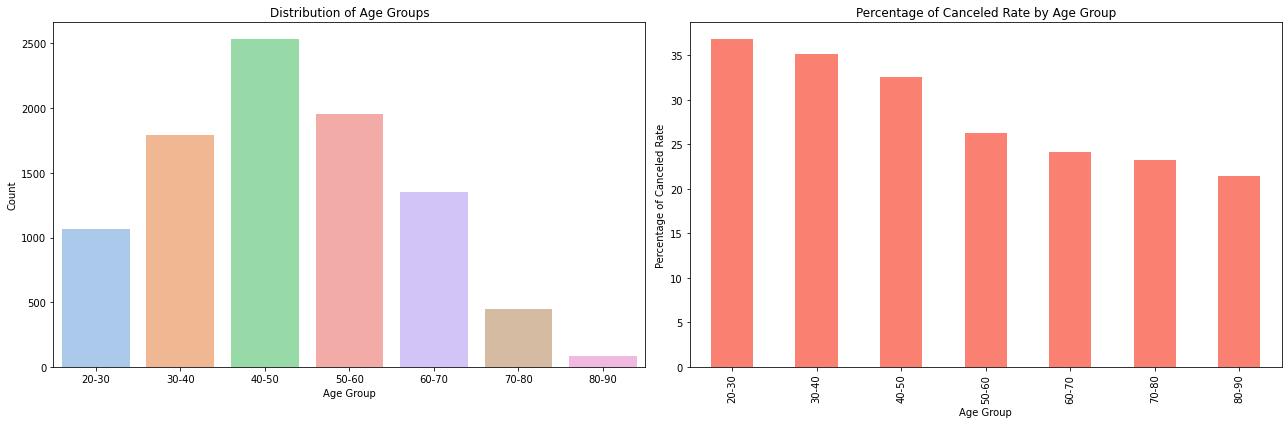

In [2]:
# Reloading the raw data
df = pd.read_excel(paths.RAW_DATA + "/club_churn_train.xlsx")

# Grouping the age column using pandas.cut
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
df['AGE_GROUP'] = pd.cut(df['MEMBER_AGE_AT_ISSUE'], bins=bins, labels=labels, right=False)
# Calculating the percentage of canceled rate for each age group
canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('AGE_GROUP').size() / df.groupby('AGE_GROUP').size() * 100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plotting the distribution of age groups
sns.countplot(data=df, x='AGE_GROUP', ax=axes[0], palette='pastel')
axes[0].set_title('Distribution of Age Groups')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Age Group')

# Plotting the percentage of canceled rate for each age group
canceled_rate.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Age Group')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Age Group')

plt.tight_layout()
plt.show()

In [3]:
canceled_rate

AGE_GROUP
20-30    36.856876
30-40    35.153203
40-50    32.610410
50-60    26.280738
60-70    24.148148
70-80    23.214286
80-90    21.428571
dtype: float64

## 2. Gener/Marital status impact the cancel rate? 

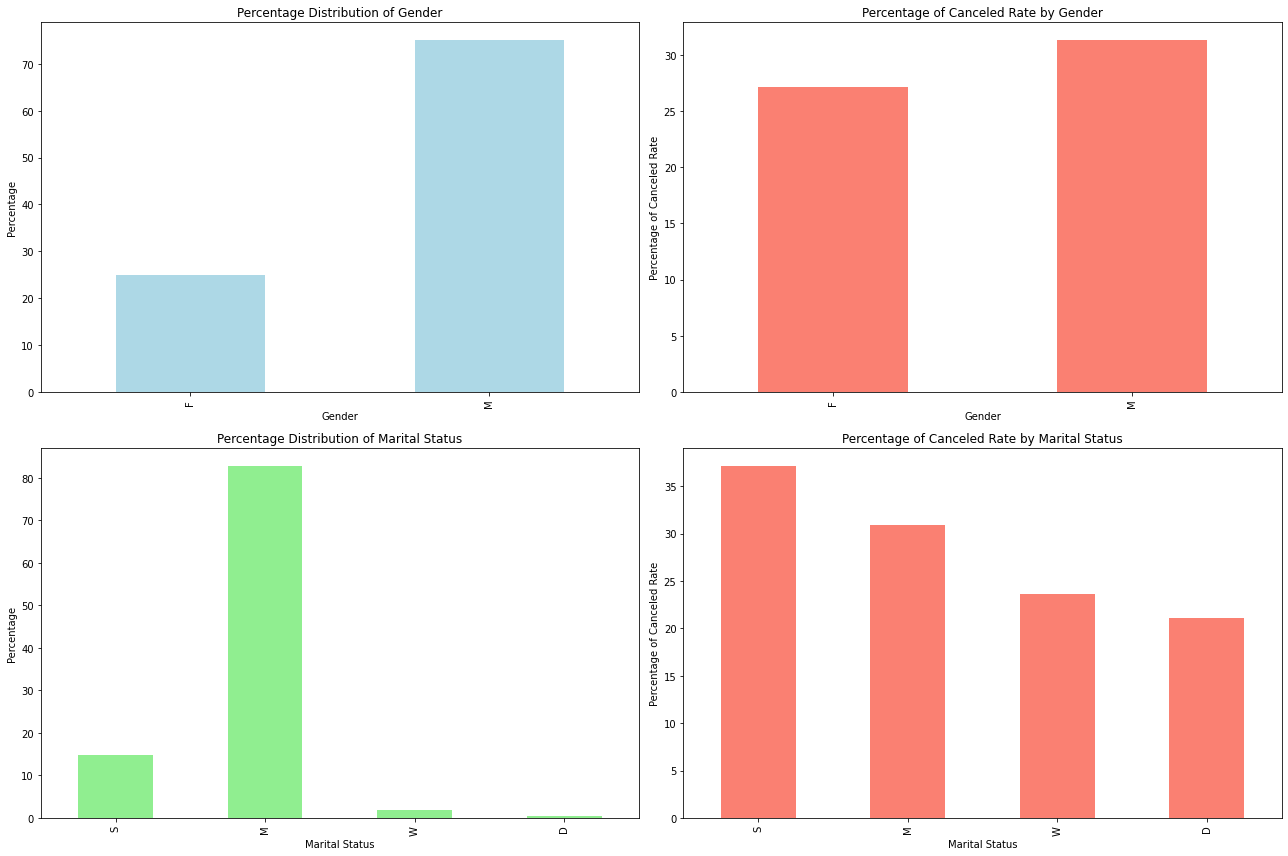

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# Calculating the percentage distribution of MEMBER_GENDER
gender_percentage = df['MEMBER_GENDER'].value_counts(normalize=True) * 100

# Plotting the percentage distribution of MEMBER_GENDER
gender_percentage.sort_index().plot(kind='bar', ax=axes[0, 0], color='lightblue')
axes[0, 0].set_title('Percentage Distribution of Gender')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].set_xlabel('Gender')

# Calculating the percentage of canceled rate for each gender
gender_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('MEMBER_GENDER').size() / df.groupby('MEMBER_GENDER').size() * 100

# Plotting the percentage of canceled rate for each gender
gender_canceled_rate.plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Percentage of Canceled Rate by Gender')
axes[0, 1].set_ylabel('Percentage of Canceled Rate')
axes[0, 1].set_xlabel('Gender')

# Calculating the percentage distribution of MEMBER_MARITAL_STATUS
marital_status_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('MEMBER_MARITAL_STATUS').size() / df.groupby('MEMBER_MARITAL_STATUS').size() * 100
marital_status_canceled_rate_sorted = marital_status_canceled_rate.sort_values(ascending=False)
marital_status_percentage = df['MEMBER_MARITAL_STATUS'].value_counts(normalize=True) * 100
marital_status_percentage_sorted = marital_status_percentage.reindex(marital_status_canceled_rate_sorted.index)

# Plotting the percentage distribution of MEMBER_MARITAL_STATUS
marital_status_percentage_sorted.plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Percentage Distribution of Marital Status')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_xlabel('Marital Status')

# Plotting the percentage of canceled rate for each marital status
marital_status_canceled_rate_sorted.plot(kind='bar', ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Percentage of Canceled Rate by Marital Status')
axes[1, 1].set_ylabel('Percentage of Canceled Rate')
axes[1, 1].set_xlabel('Marital Status')

plt.tight_layout()
plt.show()

## 3. Higher income will low canel rate?

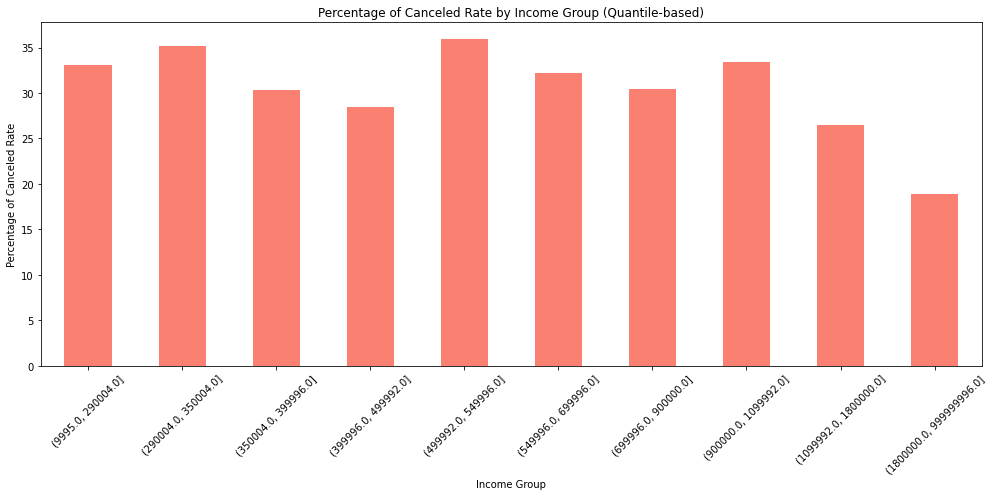

In [5]:
# Binning the income using qcut to create quantile-based income groups
df['Income_Group_Quantile'] = pd.qcut(df['MEMBER_ANNUAL_INCOME'], q=10, precision=0)

# Calculating the percentage of canceled rate for each quantile-based income group
income_quantile_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('Income_Group_Quantile').size() / df.groupby('Income_Group_Quantile').size() * 100

# Plotting the percentage of canceled rate for each quantile-based income group
plt.figure(figsize=(14, 7))
income_quantile_canceled_rate.plot(kind='bar', color='salmon')
plt.title('Percentage of Canceled Rate by Income Group (Quantile-based)')
plt.ylabel('Percentage of Canceled Rate')
plt.xlabel('Income Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Certain professions will have higher cancel rate?

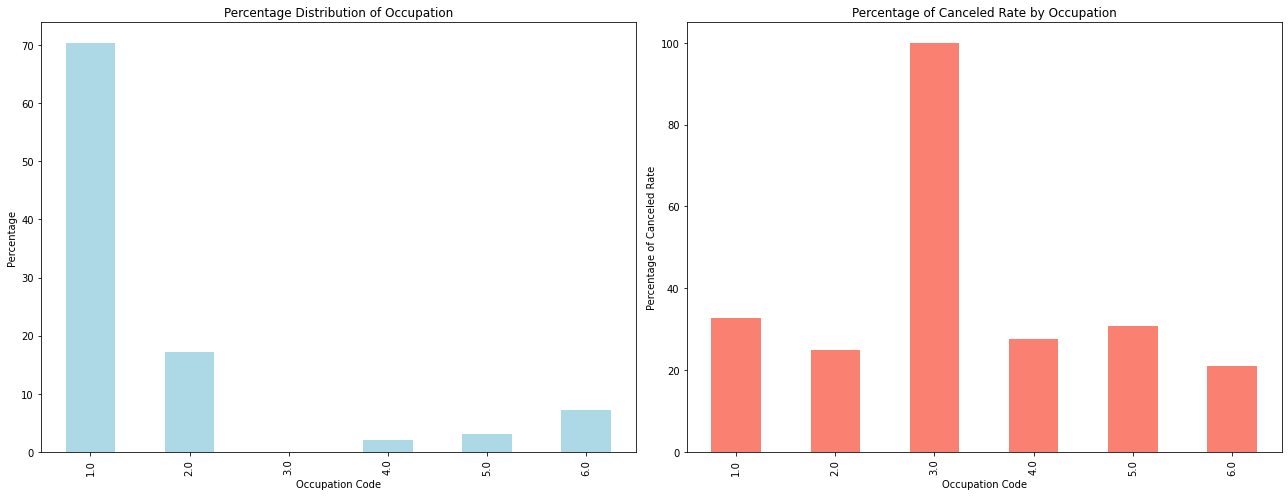

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Calculating the percentage distribution of MEMBER_OCCUPATION_CD
occupation_percentage = df['MEMBER_OCCUPATION_CD'].value_counts(normalize=True) * 100

# Plotting the percentage distribution of MEMBER_OCCUPATION_CD
occupation_percentage.sort_index().plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title('Percentage Distribution of Occupation')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Occupation Code')

# Calculating the percentage of canceled rate for each occupation
occupation_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('MEMBER_OCCUPATION_CD').size() / df.groupby('MEMBER_OCCUPATION_CD').size() * 100

# Plotting the percentage of canceled rate for each occupation
occupation_canceled_rate.sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Occupation')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Occupation Code')

plt.tight_layout()
plt.show()

## 5. Those go with extra persons will have higher retain? -> suggest to offer couple

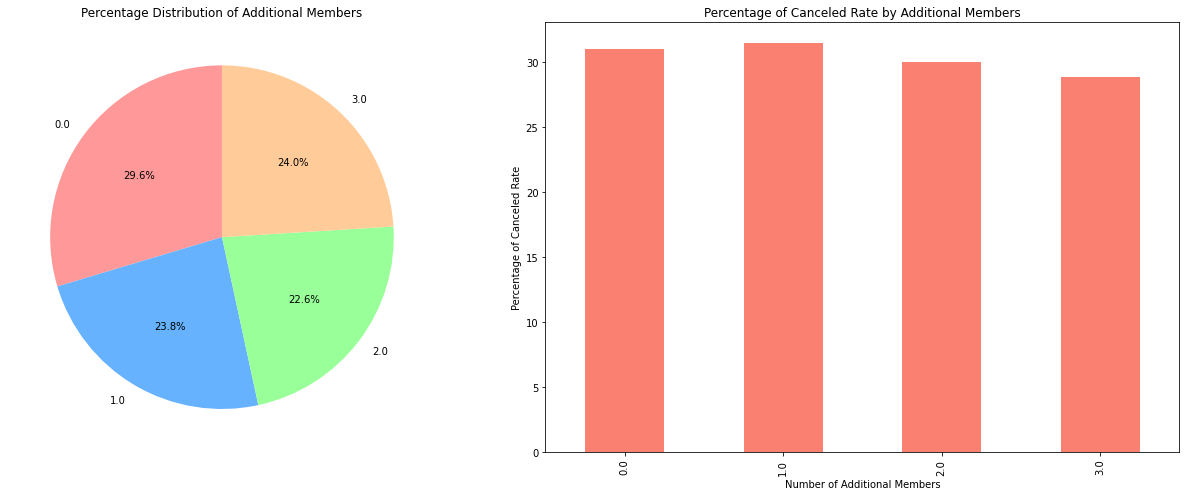

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

additional_members_percentage = df['ADDITIONAL_MEMBERS'].value_counts(normalize=True) * 100
# Plotting the percentage distribution of ADDITIONAL_MEMBERS as a pie chart
additional_members_percentage.sort_index().plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
axes[0].set_title('Percentage Distribution of Additional Members')
axes[0].set_ylabel('')

# Plotting the percentage of canceled rate for each additional member count
additional_members_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('ADDITIONAL_MEMBERS').size() / df.groupby('ADDITIONAL_MEMBERS').size() * 100
additional_members_canceled_rate.sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Additional Members')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Number of Additional Members')

plt.tight_layout()
plt.show()

## 6. Membership packages have different retention rate?

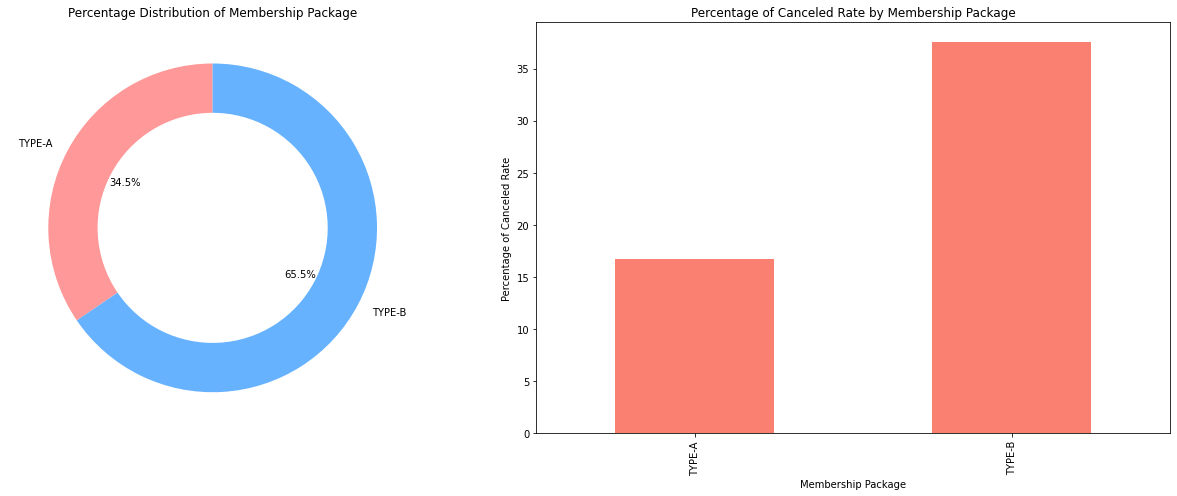

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Calculating the percentage distribution of MEMBERSHIP_PACKAGE
membership_package_percentage = df['MEMBERSHIP_PACKAGE'].value_counts(normalize=True) * 100

# Plotting the percentage distribution of MEMBERSHIP_PACKAGE as a donut chart
membership_package_percentage.sort_index().plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'], wedgeprops=dict(width=0.3))
axes[0].set_title('Percentage Distribution of Membership Package')
axes[0].set_ylabel('')

# Calculating the percentage of canceled rate for each membership package
membership_package_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('MEMBERSHIP_PACKAGE').size() / df.groupby('MEMBERSHIP_PACKAGE').size() * 100

# Plotting the percentage of canceled rate for each membership package
membership_package_canceled_rate.sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Membership Package')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Membership Package')

plt.tight_layout()
plt.show()

## 7. Duration of membership?

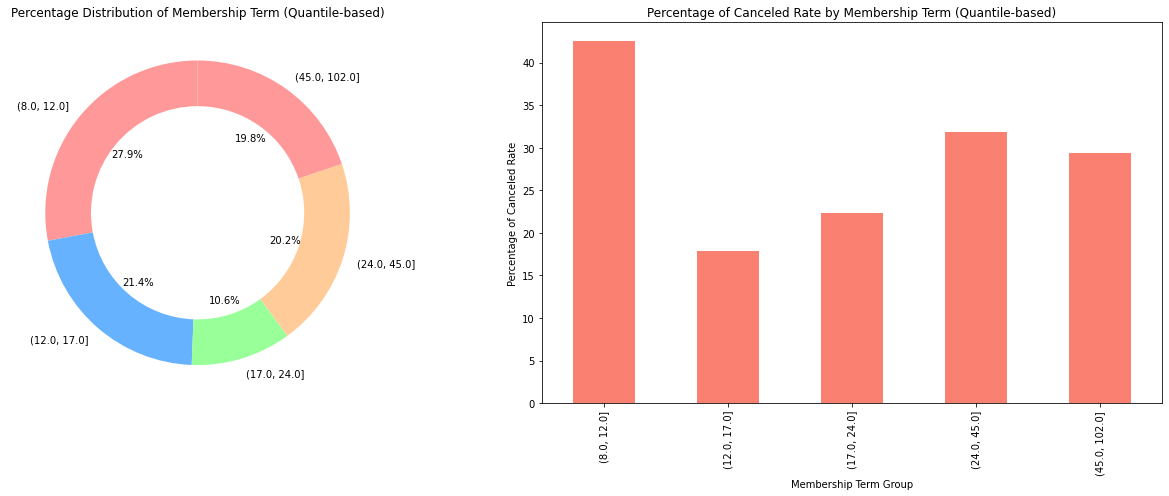

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Binning the MEMBERSHIP_TERM_YEARS using qcut to create quantile-based term groups
df['Term_Group_Quantile'] = pd.qcut(df['MEMBERSHIP_TERM_YEARS'], q=5, precision=0)

# Calculating the percentage distribution of Term_Group_Quantile
term_group_percentage = df['Term_Group_Quantile'].value_counts(normalize=True) * 100

# Plotting the percentage distribution of Term_Group_Quantile as a donut chart
term_group_percentage.sort_index().plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'], wedgeprops=dict(width=0.3))
axes[0].set_title('Percentage Distribution of Membership Term (Quantile-based)')
axes[0].set_ylabel('')

# Calculating the percentage of canceled rate for each quantile-based term group
term_group_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('Term_Group_Quantile').size() / df.groupby('Term_Group_Quantile').size() * 100

# Plotting the percentage of canceled rate for each quantile-based term group
term_group_canceled_rate.sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Membership Term (Quantile-based)')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Membership Term Group')

plt.tight_layout()
plt.show()

- Suggest to use the longer term package

## 8. Annual fees

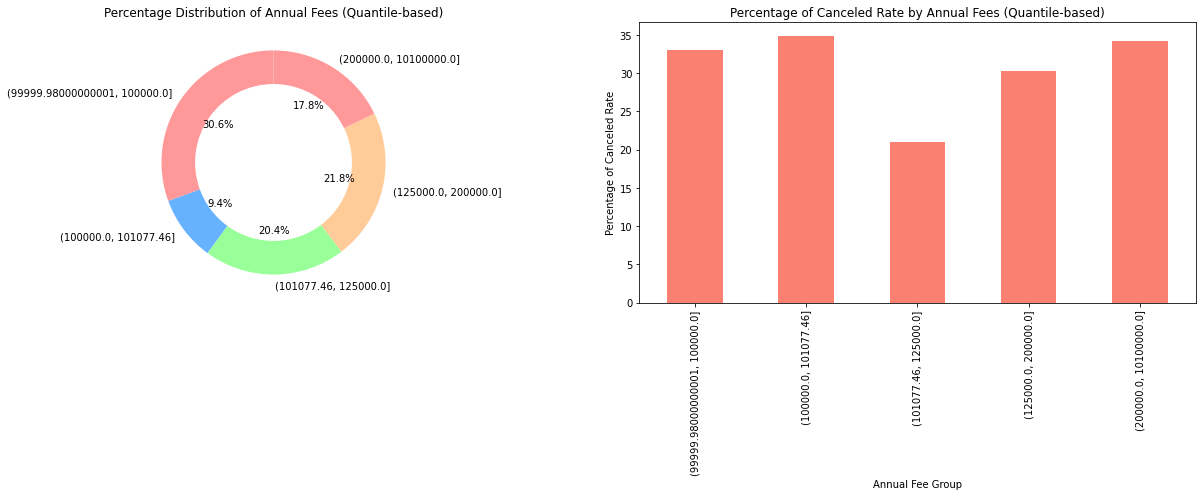

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Binning the ANNUAL_FEES using qcut to create quantile-based fee groups
df['Fee_Group_Quantile'] = pd.qcut(df['ANNUAL_FEES'], q=5, precision=0)

# Calculating the percentage distribution of Fee_Group_Quantile
fee_group_percentage = df['Fee_Group_Quantile'].value_counts(normalize=True) * 100

# Plotting the percentage distribution of Fee_Group_Quantile as a donut chart
fee_group_percentage.sort_index().plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'], wedgeprops=dict(width=0.3))
axes[0].set_title('Percentage Distribution of Annual Fees (Quantile-based)')
axes[0].set_ylabel('')

# Calculating the percentage of canceled rate for each quantile-based fee group
fee_group_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('Fee_Group_Quantile').size() / df.groupby('Fee_Group_Quantile').size() * 100

# Plotting the percentage of canceled rate for each quantile-based fee group
fee_group_canceled_rate.sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Annual Fees (Quantile-based)')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Annual Fee Group')

plt.tight_layout()
plt.show()

- The fees should not be too high or too low, the best threshold should be the middle
- It should be under 10% of their income

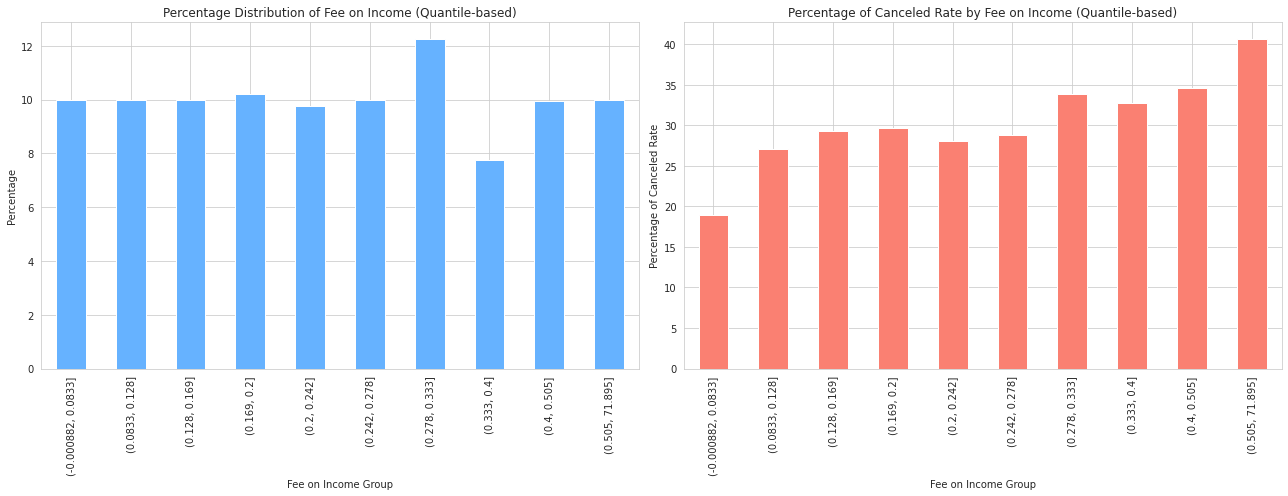

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Creating the new feature 'FEE_ON_INCOME'
df['FEE_ON_INCOME'] = df['ANNUAL_FEES'] / df['MEMBER_ANNUAL_INCOME']

# Binning the FEE_ON_INCOME using qcut to create quantile-based groups
df['FEE_ON_INCOME_Group'] = pd.qcut(df['FEE_ON_INCOME'], q=10, precision=3)

# Calculating the percentage distribution of FEE_ON_INCOME_Group
fee_on_income_group_percentage = df['FEE_ON_INCOME_Group'].value_counts(normalize=True) * 100

# Plotting the percentage distribution of FEE_ON_INCOME_Group as a bar chart with a single blue color
fee_on_income_group_percentage.sort_index().plot(kind='bar', ax=axes[0], color='#66B2FF')
axes[0].set_title('Percentage Distribution of Fee on Income (Quantile-based)')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Fee on Income Group')

# Calculating the percentage of canceled rate for each quantile-based fee on income group
fee_on_income_group_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('FEE_ON_INCOME_Group').size() / df.groupby('FEE_ON_INCOME_Group').size() * 100
# Plotting the percentage of canceled rate for each quantile-based fee on income group
fee_on_income_group_canceled_rate.sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Fee on Income (Quantile-based)')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Fee on Income Group')

plt.tight_layout()
plt.show()

## 9. Payment mode?

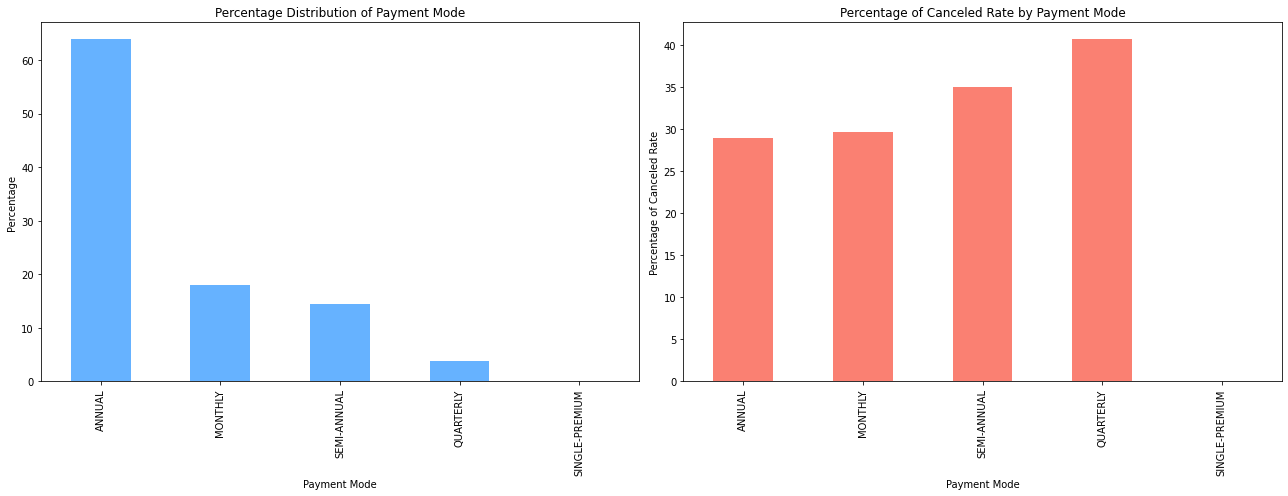

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
payment_mode_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('PAYMENT_MODE').size() / df.groupby('PAYMENT_MODE').size() * 100
sorted_payment_modes = payment_mode_canceled_rate.sort_values().index
# Sorting the payment modes by their canceled rate
sorted_payment_modes = payment_mode_canceled_rate.sort_values().index

# Plotting the percentage distribution of PAYMENT_MODE as a bar chart (sorted by canceled rate)
payment_mode_percentage = df['PAYMENT_MODE'].value_counts(normalize=True) * 100
payment_mode_percentage[sorted_payment_modes].plot(kind='bar', ax=axes[0], color='#66B2FF')
axes[0].set_title('Percentage Distribution of Payment Mode')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Payment Mode')

# Plotting the percentage of canceled rate for each payment mode (sorted)
payment_mode_canceled_rate[sorted_payment_modes].plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Payment Mode')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Payment Mode')

plt.tight_layout()
plt.show()

## 10. Agent influence?

In [19]:
df.AGENT_CODE.value_counts().head(10)

343344.0     553
348355.0     105
343477.0      87
343466.0      58
309877.0      57
1347266.0     50
1079488.0     46
739255.0      46
1219222.0     43
343377.0      39
Name: AGENT_CODE, dtype: int64

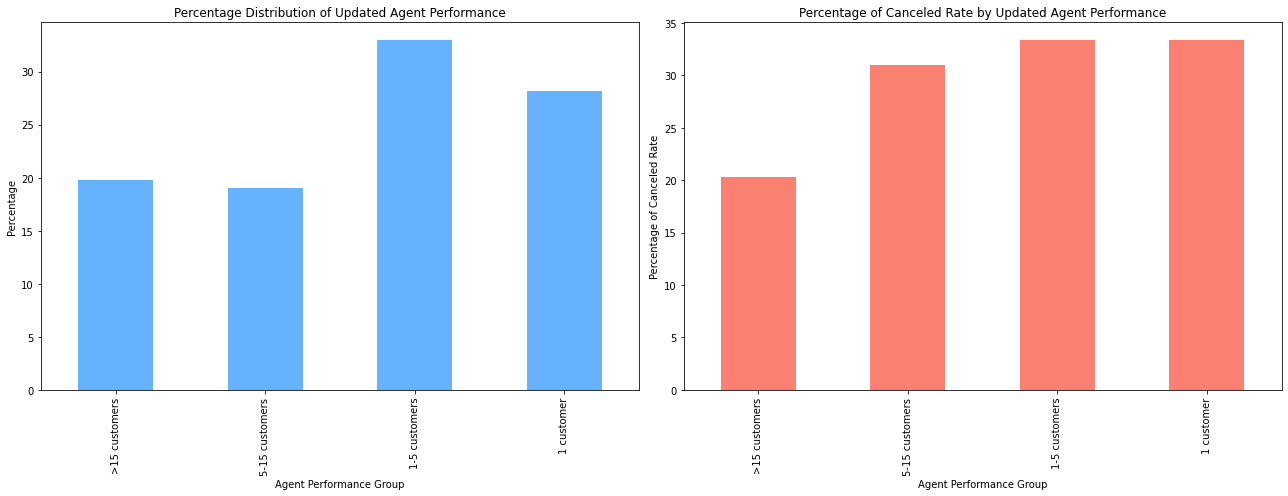

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Re-grouping the agent codes based on the updated performance groups
agent_customer_counts = df['AGENT_CODE'].value_counts()
updated_agent_performance_groups = agent_customer_counts.map(lambda x: '1 customer' if x == 1 else
                                                            '1-5 customers' if 1 < x <= 5 else
                                                            '5-15 customers' if 5 < x <= 15 else
                                                            '>15 customers')
df['UPDATED_AGENT_PERFORMANCE'] = df['AGENT_CODE'].map(updated_agent_performance_groups)

# Calculating the percentage distribution of UPDATED_AGENT_PERFORMANCE
updated_agent_performance_percentage = df['UPDATED_AGENT_PERFORMANCE'].value_counts(normalize=True) * 100

# Calculating the percentage of canceled rate for each updated agent performance group
updated_agent_performance_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('UPDATED_AGENT_PERFORMANCE').size() / df.groupby('UPDATED_AGENT_PERFORMANCE').size() * 100

# Sorting the performance groups by their canceled rate
sorted_performance_groups = updated_agent_performance_canceled_rate.sort_values().index

# Plotting the percentage distribution of UPDATED_AGENT_PERFORMANCE as a bar chart (sorted by canceled rate)
updated_agent_performance_percentage[sorted_performance_groups].plot(kind='bar', ax=axes[0], color='#66B2FF')
axes[0].set_title('Percentage Distribution of Updated Agent Performance')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Agent Performance Group')

# Plotting the percentage of canceled rate for each updated agent performance group (sorted)
updated_agent_performance_canceled_rate[sorted_performance_groups].plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of Canceled Rate by Updated Agent Performance')
axes[1].set_ylabel('Percentage of Canceled Rate')
axes[1].set_xlabel('Agent Performance Group')

plt.tight_layout()
plt.show()

## 11. Start date -> improve service over time -> past bad, now good

In [21]:
df = pd.read_excel(paths.RAW_DATA + "/club_churn_train.xlsx")

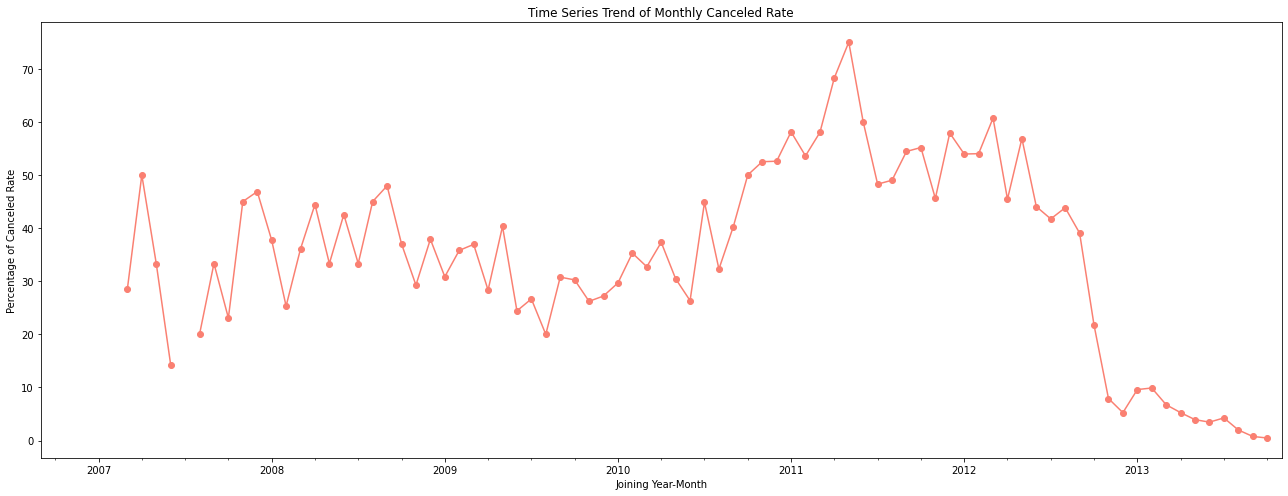

In [22]:
fig, ax = plt.subplots(figsize=(18, 7))

# Converting the START_DATE column to datetime format
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%Y%m%d')

# Extracting the year-month from the START_DATE column
df['JOINING_YEAR_MONTH'] = df['START_DATE'].dt.to_period('M')

# Calculating the monthly canceled rate
monthly_canceled_rate = df[df['MEMBERSHIP_STATUS'] == 'CANCELLED'].groupby('JOINING_YEAR_MONTH').size() / df.groupby('JOINING_YEAR_MONTH').size() * 100

# Plotting the time series trend of the monthly canceled rate
monthly_canceled_rate.plot(ax=ax, color='salmon', marker='o')
ax.set_title('Time Series Trend of Monthly Canceled Rate')
ax.set_ylabel('Percentage of Canceled Rate')
ax.set_xlabel('Joining Year-Month')

plt.tight_layout()
plt.show()

/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


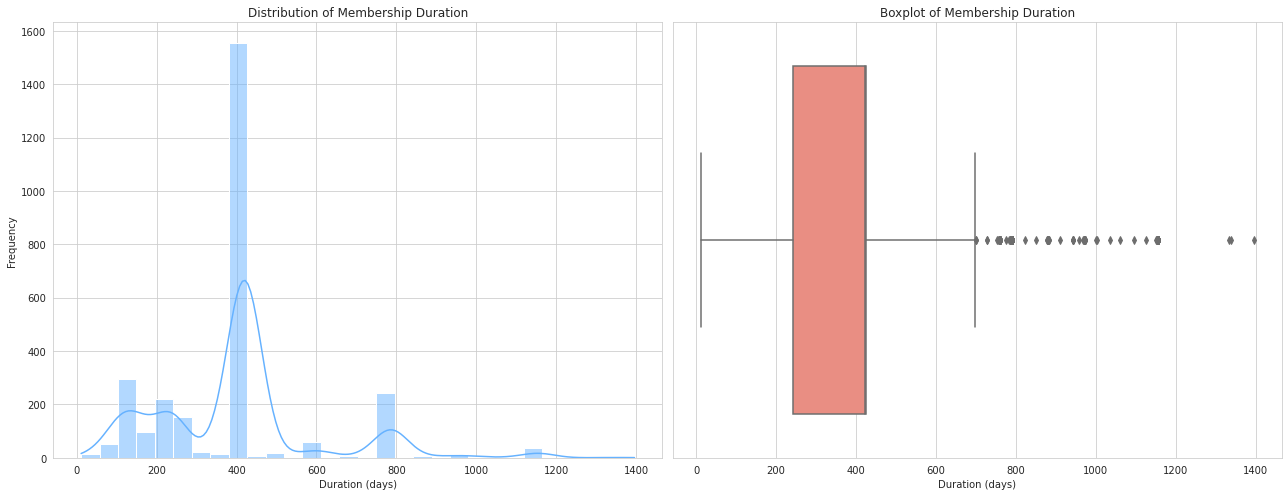

In [82]:
# Converting START_DATE and END_DATE to datetime format
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%Y%m%d')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], format='%Y%m%d')

# Calculating the duration between START_DATE and END_DATE
df['DURATION'] = (df['END_DATE'] - df['START_DATE']).dt.days

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Plotting the distribution of duration using a histogram
sns.histplot(df['DURATION'], ax=axes[0], bins=30, color='#66B2FF', kde=True)
axes[0].set_title('Distribution of Membership Duration')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Duration (days)')

# Plotting the distribution of duration using a boxplot
sns.boxplot(df['DURATION'], ax=axes[1], color='salmon')
axes[1].set_title('Boxplot of Membership Duration')
axes[1].set_xlabel('Duration (days)')

plt.tight_layout()
plt.show()

## Any difference about CANCELLED RATE between AGE at ISSUE goup over time?

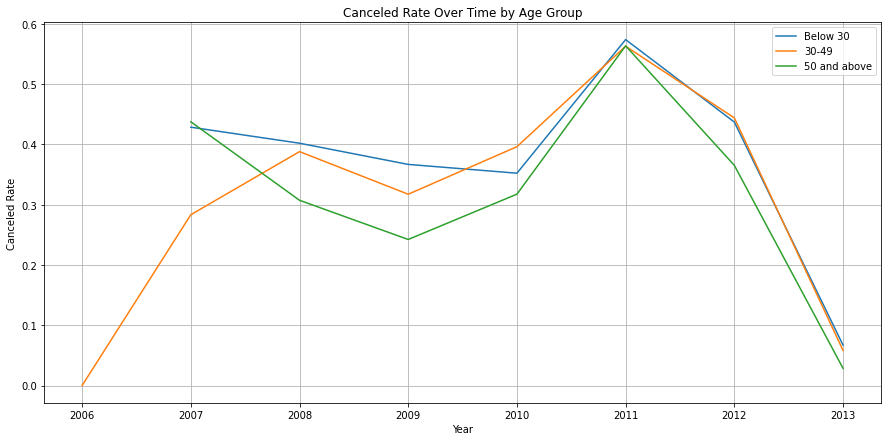

In [91]:
# Grouping AGE_AT_ISSUE into specified bins
bins = [0, 29, 49, np.inf]
labels = ['Below 30', '30-49', '50 and above']
df['Age_Group'] = pd.cut(df['MEMBER_AGE_AT_ISSUE'], bins=bins, labels=labels, right=True)

# Extracting year from START_DATE
df['Year'] = pd.to_datetime(df['START_DATE'], format='%Y%m%d').dt.year

# Calculating canceled rate for each age group and year
canceled_rate = df.groupby(['Age_Group', 'Year'])['MEMBERSHIP_STATUS'].apply(lambda x: (x == 'CANCELLED').mean()).reset_index()

# Plotting
plt.figure(figsize=(15, 7))
for age_group in labels:
    subset = canceled_rate[canceled_rate['Age_Group'] == age_group]
    plt.plot(subset['Year'], subset['MEMBERSHIP_STATUS'], label=age_group)

plt.title('Canceled Rate Over Time by Age Group')
plt.xlabel('Year')
plt.ylabel('Canceled Rate')
plt.legend()
plt.grid(True)
plt.show()

- So what make the group registered at 2010, 2011 and 2012 stay with us longer instead of churn as the general trend -> make our model make wrong prediction
- Add the feature how long they stay with us, if pass 400 days --> more safe, if not it is more uncertain

## If they pass the threshold 400days -> low cancelled rate?

In [132]:
df['START_DATE'] = pd.to_datetime(df.START_DATE, format="%Y%m%d")

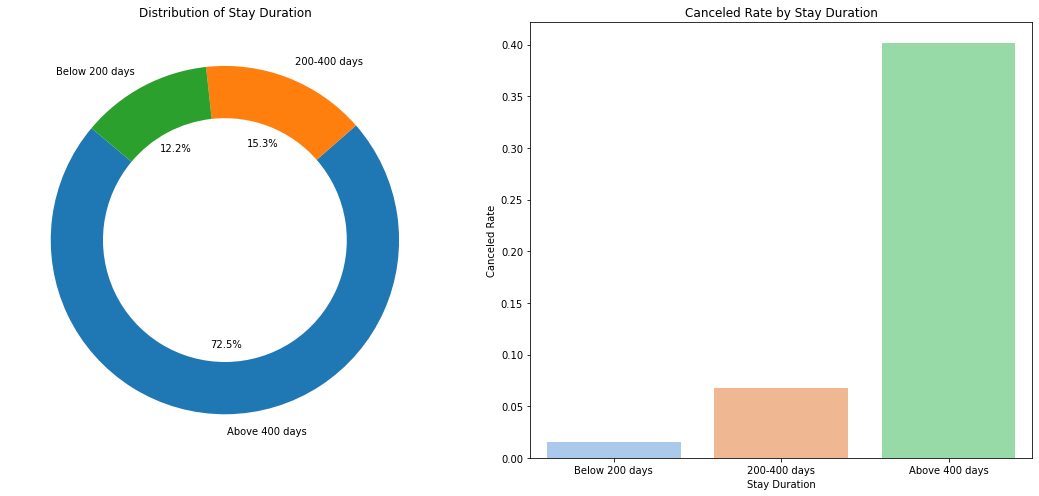

In [134]:
# Calculating days_stay using the provided current date
current_date = datetime(2014,1,1)
df['days_stay'] = (current_date - df['START_DATE']).dt.days

stay_bins = [0, 200, 400, np.inf]
stay_labels = ['Below 200 days', '200-400 days', 'Above 400 days']
df['Stay_Group'] = pd.cut(df['days_stay'], bins=stay_bins, labels=stay_labels, right=True)

# Calculating canceled rate for each stay group
canceled_rate_stay = df.groupby('Stay_Group')['MEMBERSHIP_STATUS'].apply(lambda x: (x == 'CANCELLED').mean()).reset_index()
stay_distribution = df['Stay_Group'].value_counts(normalize=True).reset_index()
stay_distribution.columns = ['Stay_Group', 'Percentage']

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Donut chart for distribution
wedges, texts, autotexts = axes[0].pie(stay_distribution['Percentage'], labels=stay_distribution['Stay_Group'], autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
axes[0].set_title('Distribution of Stay Duration')

# Bar chart for canceled rate
sns.barplot(data=canceled_rate_stay, x='Stay_Group', y='MEMBERSHIP_STATUS', ax=axes[1], palette='pastel')
axes[1].set_title('Canceled Rate by Stay Duration')
axes[1].set_ylabel('Canceled Rate')
axes[1].set_xlabel('Stay Duration')

plt.tight_layout()
plt.show()